# Sensitivity Analysis of Ridge Regression using DiffOpt.jl

- This notebook illustrates sensitivity analysis of data points in a ridge regression problem. 

$$
\begin{split}
\begin{array} {ll}
\mbox{minimize} & \sum_{i=1}^{N} (y_{i} - w x_{i} - b)^2 + \alpha (w^2 + b^2) \\
\end{array}
\end{split}
$$
where
- $w$, $b$ are slope and intercept of the regressing line
- $x$, $y$ are the N data points
- $\alpha$ is regularization constant

## Define and solve

In [396]:
import Random
import OSQP
import Plots
using DiffOpt
using JuMP
using LinearAlgebra

In [397]:
function createProblem(N=100)
    m = 2*abs(randn())
    b = rand()
    X = randn(N)
    Y = m*X .+ b + randn(N)

    # test train split
    l = Int(N*0.8)
    return X[1:l], X[l+1:N], Y[1:l], Y[l+1:N]
end

X_train, X_test, Y_train, Y_test = createProblem();

In [398]:
function fitRidge(X,Y, alpha=0.1)
    model = Model(() -> diff_optimizer(OSQP.Optimizer))

    # add variables
    @variable(model, w)
    @variable(model, b)
    set_optimizer_attribute(model, MOI.Silent(), true)
    
    @objective(
        model,
        Min,
        sum((Y - w*X .- b).*(Y - w*X .- b)) + alpha*(sum(w*w)+sum(b*b)),
    )

    optimize!(model)

    loss = objective_value(model)
    return model, w, b, loss, value(w), value(b)
end

fitRidge (generic function with 2 methods)

In [399]:
model, w, b, loss_train, w_train, b_train = fitRidge(X_train, Y_train)
_, _, _, loss_test, w_test, b_test = fitRidge(X_test, Y_test);

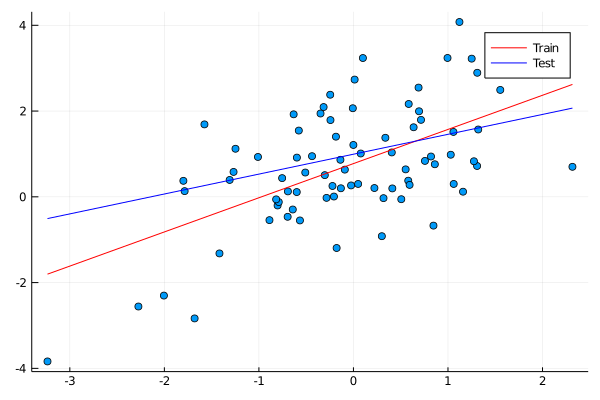

In [400]:
p = Plots.scatter(X_train, Y_train, label="")
mi, ma = minimum(X_train), maximum(X_train)
Plots.plot!(p, [mi, ma], [mi*w_train+b_train, ma*w_train+b_train], color=:red, label="Train")
Plots.plot!(p, [mi, ma], [mi*w_test+b_test, ma*w_test+b_test ], color=:blue, label="Test")

## Part 2: Differentiate wrt each data point

In [401]:
∇ = zero(X_train)

for i in 1:length(X_train)
    MOI.set(
        model,
        DiffOpt.ForwardIn{DiffOpt.LinearObjective}(), 
        w, 
        -2*(Y_train[i] + X_train[i])
    ) 
    MOI.set(
        model, 
        DiffOpt.ForwardIn{DiffOpt.QuadraticObjective}(), 
        w,
        w,
        2*X_train[i]
    )
    
    DiffOpt.forward(model)
    
    db = MOI.get(
        model,
        DiffOpt.ForwardOut{MOI.VariablePrimal}(), 
        b
    )

    ∇[i] = db
end
normalize!(∇);

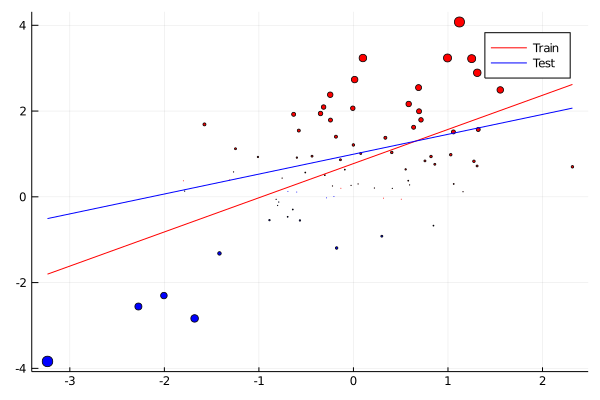

In [402]:
p = Plots.scatter(
    X_train, Y_train,
    color=[x>0 ? :red : :blue for x in ∇],
    markersize=[20*abs(x) for x in ∇],
    label=""
)
mi, ma = minimum(X_train), maximum(X_train)
Plots.plot!(p, [mi, ma], [mi*w_train+b_train, ma*w_train+b_train], color=:red, label="Train")
Plots.plot!(p, [mi, ma], [mi*w_test+b_test, ma*w_test+b_test ], color=:blue, label="Test")